<h1>Отбор модели</h1>

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import gc
import warnings
from sklearn import (ensemble, model_selection, discriminant_analysis,
                     naive_bayes, linear_model, neighbors, tree, svm, metrics)
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from functools import partial
from tqdm import notebook
import matplotlib.pyplot as plt

gc.enable()
warnings.filterwarnings("ignore")

Напишем функцию для тестирования модели

In [2]:
def model_test(model, x_train, x_valid, y_train, y_true):
    clf = model
    clf.fit(x_train, y_train)
    f1 = metrics.f1_score(y_true, clf.predict(x_valid), average="binary")
    name = (
        str(clf)[:str(clf).rfind('(')]
        if "CatBoostClassifier" not in str(clf) else "CatBoostClassifier"
    )
    with open("default_models.txt", 'a', encoding="utf-8") as file:
        file.write(f"{name}: {round(f1, 5)}\n")

Загрузим обработанные данные, полученные после проведения EDA

In [3]:
data = pd.read_csv("data/scoring_processed.csv")

Обозначим категориальные признаки, признаки, используемые для обучения

In [4]:
cols = data.columns[1:-2].tolist()
full_cols = data.columns[1:]
cat_features = ["RealEstateLoansOrLines", "GroupAge"]

Для отбора модели будем использовать самую простую схему валидации - `HoldOut`  
Разделим данные на трейн и валидационную части

In [5]:
train, valid, _, _ = model_selection.train_test_split(
    data,
    data["SeriousDlqin2yrs"],
    test_size=0.25,
    stratify=data["SeriousDlqin2yrs"],
    shuffle=True,
    random_state=5432
)

Зафиксируем некоторые аргументы функции `model_test`

In [6]:
model_testing = partial(
    model_test,
    x_train=train[cols],
    x_valid=valid[cols], 
    y_train=train["SeriousDlqin2yrs"],
    y_true=valid["SeriousDlqin2yrs"]
)

В качестве кандидатов будем использовать следующие алгоритмы:  
    - алгоритмы семейства `naive_bayes` - GaussianNB, MultinomialNB, BernoulliNB, ComplementNB;  
    - `деревянные` алгоритмы - DecisionTreeClassifier, RandomForestClassifier, ExtraTreesClassifier;  
    - `линейные` алгоритмы - LogisticRegression, LinearSVC, RidgeClassifier;  
    - `метрические` алгоритмы - KNeighborsClassifier;  
    - алгоритмы `бустинговых` семейств - GradientBoostingClassifier, CatBoostClassifier, LGBMClassifier, XGBClassifier, HistGradientBoostingClassifier;  
    - алгоритмы `дискриминантного анализа` - LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
    
Оценивать алгоритмы будем по метрике - `f1`

In [7]:
np.random.seed(5432)

algos = (
    naive_bayes.GaussianNB(),
    naive_bayes.MultinomialNB(),
    naive_bayes.BernoulliNB(),
    naive_bayes.ComplementNB(),
    neighbors.KNeighborsClassifier(),
    linear_model.LogisticRegression(),
    tree.DecisionTreeClassifier(),
    ensemble.RandomForestClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    svm.LinearSVC(),
    cb.CatBoostClassifier(verbose=0),
    lgb.LGBMClassifier(verbose=0),
    xgb.XGBClassifier(verbose=0),
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    ensemble.HistGradientBoostingClassifier(),
    linear_model.RidgeClassifier(),
)

for alg in notebook.tqdm(algos):
    model_testing(alg)
    
del algos

  0%|          | 0/18 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[16:11:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



Загрузим и представим результаты обучения выбранных алгоритмов

In [8]:
with open("default_models.txt", 'r', encoding="utf-8") as file:
    res = list(map(lambda x: x.strip().split(':'), file.readlines()))

In [9]:
pd.DataFrame(columns=["model", "f1"], data=res).sort_values(by="f1", ascending=False)

,model,f1
12,LGBMClassifier,0.72408
11,CatBoostClassifier,0.72399
13,XGBClassifier,0.72197
16,HistGradientBoostingClassifier,0.72124
7,RandomForestClassifier,0.71647
8,ExtraTreesClassifier,0.71253
9,GradientBoostingClassifier,0.70558
2,BernoulliNB,0.63971
14,LinearDiscriminantAnalysis,0.63934
17,RidgeClassifier,0.63934


Самым лучшим оказался алгоритм - `LGBMClassifier`  
Совсем немного от него отстаёт - `CatBoostClassifier`  
`LGBMClassifier` обучается быстрее в силу своей реализации, однако для данного набора данных и `CatBoostClassifier` обучается не так долго  
Однако `CatBoostClassifier` имеет больший простор по выбору и подбору гиперпараметров алгоритма. В силу этого (и моей предвзятости) в качестве основного классификатора возьмём `CatBoostClassifier`

Напишем функцию для валидации `CatBoostClassifier`

In [10]:
def cb_validate(data, cols, cat_features=None):
    clf = cb.CatBoostClassifier(
        random_seed=5432,
        early_stopping_rounds=200,
        eval_metric="F1",
        verbose=0
    )
    kfold = model_selection.StratifiedKFold(
        n_splits=10,
        random_state=5432,
        shuffle=True
    )
    scores = []
    for train_idx, val_idx in notebook.tqdm(
        kfold.split(data[cols], data["SeriousDlqin2yrs"])
    ):
        x_train, y_train = data.loc[train_idx, cols], data.loc[train_idx, "SeriousDlqin2yrs"]
        x_val, y_val = data.loc[val_idx, cols], data.loc[val_idx, "SeriousDlqin2yrs"]
        
        train_pool = cb.Pool(x_train, y_train, cat_features=cat_features)
        valid_pool = cb.Pool(x_val, y_val, cat_features=cat_features)
        clf.fit(train_pool, eval_set=valid_pool)
        scores.append(clf.best_score_["validation"]["F1"])
        
    print(f"[MEAN]: {round(np.mean(scores), 5)} /// [STD]: {round(np.std(scores), 5)}")
    plt.plot(scores)
    plt.show()

0it [00:00, ?it/s]

[MEAN]: 0.7288 /// [STD]: 0.01488


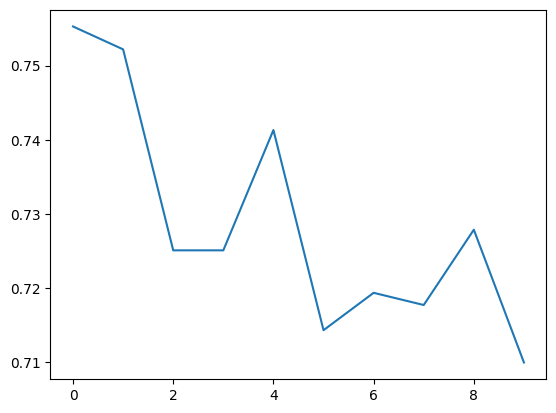

In [11]:
cb_validate(data, full_cols, cat_features=cat_features)

Тривиальным способом кодируем категориальные признаки

In [12]:
data = pd.get_dummies(data=data, columns=cat_features, drop_first=True)

Отберём признаки для обучени и провалидируем алгоритм

In [13]:
cols = data.columns[1:].tolist()

0it [00:00, ?it/s]

[MEAN]: 0.72902 /// [STD]: 0.01419


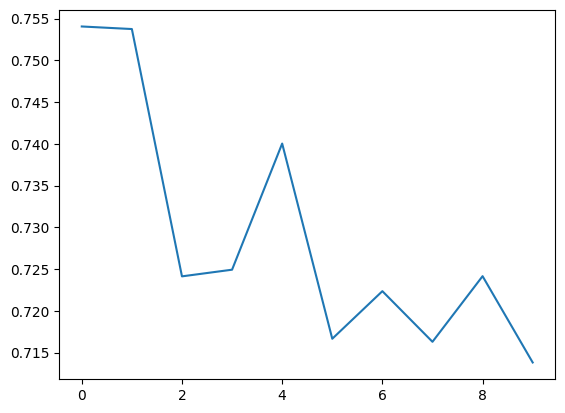

In [14]:
cb_validate(data, cols, cat_features=None)

`OHE` помогло повысить качество алгоритма, а также немного снизить переобучение
Сохраним названия признаков, использованных при обучении

In [15]:
with open("features_names.txt", "w", encoding="utf-8") as file:
    file.write('\n'.join(cols))

Соберём пул полных данных и обучим классификатор на нём. Сохраним полученные веса

In [16]:
full_train_pool = cb.Pool(
    data[cols],
    data["SeriousDlqin2yrs"],
    cat_features=None,
)

In [17]:
clf = cb.CatBoostClassifier(random_seed=5432, early_stopping_rounds=200, eval_metric="F1", verbose=200)
clf.fit(full_train_pool, eval_set=None)

Learning rate set to 0.08177
0:	learn: 0.6558672	total: 12.8ms	remaining: 12.8s
200:	learn: 0.7299904	total: 2.28s	remaining: 9.06s
400:	learn: 0.7397208	total: 4.61s	remaining: 6.88s
600:	learn: 0.7452765	total: 6.87s	remaining: 4.56s
800:	learn: 0.7502833	total: 9.33s	remaining: 2.32s
999:	learn: 0.7543331	total: 11.7s	remaining: 0us


In [18]:
clf.save_model("weights/clf")